In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"  # this is proper to Colab

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Sets the Spark master URL to connect to, such as "local" to run locally,
# "local[4]" to run locally with 4 cores,
# "local[*]"" to run with available core,
# or "spark://master:7077" to run on a Spark standalone cluster.

## Climate

### Data set

The Global Historical Climatology Network aggregates daily climate observations from about 30 observatories. The dataset is referered to as GHCN-Daily. The measurements come from 90,000+ land-based stations worldwide, about two thirds of which are for precipitation measurement only. Other meteorological elements include, but are not limited to, daily maximum and minimum temperature, temperature at the time of observation, snowfall and snow depth. Over 25,000 stations are regularly updated with observations from within roughly the last month.  


**Reference**

*Menne, Matthew J., Imke Durre, Bryant Korzeniewski, Shelley McNeal, Kristy Thomas, Xungang Yin, Steven Anthony, Ron Ray, Russell S. Vose, Byron E.Gleason, and Tamara G. Houston (2012): Global Historical Climatology Network - Daily (GHCN-Daily), Version 3. NOAA National Climatic Data Center. doi:10.7289/V5D21VHZ*

**Download**

- Data : ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/
- DataSet description : https://docs.opendata.aws/noaa-ghcn-pds/readme.html
- List of stations : http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt
- Station code of Strasbourg-Entzheim : FR000007190
- A test sample: 2015.csv restricted to data for Strasbourg-Entzheim: [download here (csv)](http://icps.u-strasbg.fr/~genaud/courses/data/strasbg_2015.csv)



### Project
Discuss the evolution of temperatures (optionally precipitations) through the years. You will choose:
- the geographical points studied
- the period of study
- the statistical computations carried out. The statistics may include:
   + year averages or quarter averages (moving average is certainly better).
   + standard deviation
   + temparatures of the 1st-quartile and 3rd-quartile (or some other percentile that you find relevant)
   + number of days with rain
   + correlation between the temperature evolution in different locations
   + correlation between precipitation and temperature levels
   + ...

You might have a look at the BerkeleyEarth site to choose your metrics.
http://berkeleyearth.lbl.gov/locations/49.03N-2.45E


The work is to be handed in as a notebook so that the computations can be checked easily. The durations of long computations using the notebook execution engine should be indicated in the text. If you use a cluster to produce some of the results, indicate the computation duration with respect to the number of cores used.

A graphical presentation of the results will be greatly appreciated.


In [4]:
!wget http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/1950.csv.gz
!wget http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/1970.csv.gz
!wget http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/1990.csv.gz
!wget http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/2010.csv.gz
!wget http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/2018.csv.gz
!wget http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/2015.csv.gz

--2024-10-21 20:02:55--  http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/1950.csv.gz
Resolving noaa-ghcn-pds.s3.amazonaws.com (noaa-ghcn-pds.s3.amazonaws.com)... 52.216.33.145, 3.5.30.204, 52.216.153.148, ...
Connecting to noaa-ghcn-pds.s3.amazonaws.com (noaa-ghcn-pds.s3.amazonaws.com)|52.216.33.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101141169 (96M) [application/octet-stream]
Saving to: ‘1950.csv.gz’

1950.csv.gz         100%[===================>]  96.46M  19.1MB/s    in 6.4s    

2024-10-21 20:03:02 (15.1 MB/s) - ‘1950.csv.gz’ saved [101141169/101141169]

--2024-10-21 20:03:02--  http://noaa-ghcn-pds.s3.amazonaws.com/csv.gz/1970.csv.gz
Resolving noaa-ghcn-pds.s3.amazonaws.com (noaa-ghcn-pds.s3.amazonaws.com)... 52.217.164.201, 3.5.10.223, 3.5.24.140, ...
Connecting to noaa-ghcn-pds.s3.amazonaws.com (noaa-ghcn-pds.s3.amazonaws.com)|52.217.164.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142152184 (136M) [application/oct

In [6]:
# a simplified dataset with only Strasbourg for 2015
!wget http://icps.u-strasbg.fr/~genaud/courses/data/strasbg_2015.csv

--2024-10-21 17:09:39--  http://icps.u-strasbg.fr/~genaud/courses/data/strasbg_2015.csv
Resolving icps.u-strasbg.fr (icps.u-strasbg.fr)... 130.79.201.120
Connecting to icps.u-strasbg.fr (icps.u-strasbg.fr)|130.79.201.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49610 (48K) [text/csv]
Saving to: ‘strasbg_2015.csv’

strasbg_2015.csv    100%[===================>]  48.45K   203KB/s    in 0.2s    

2024-10-21 17:09:40 (203 KB/s) - ‘strasbg_2015.csv’ saved [49610/49610]



In [7]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("StrasbourgData").getOrCreate()
df = spark.read.csv("strasbg_2015.csv")
df.show(n=10)

+-----------+--------+----+---+----+----+---+----+
|        _c0|     _c1| _c2|_c3| _c4| _c5|_c6| _c7|
+-----------+--------+----+---+----+----+---+----+
|FR000007190|20150101|TMAX|  4|NULL|NULL|  E|NULL|
|FR000007190|20150101|TMIN|-56|NULL|NULL|  E|NULL|
|FR000007190|20150101|PRCP|  0|NULL|NULL|  E|NULL|
|FR000007190|20150101|TAVG|-18|   H|NULL|  S|NULL|
|FR000007190|20150102|TMAX| 31|NULL|NULL|  E|NULL|
|FR000007190|20150102|TMIN|-24|NULL|NULL|  E|NULL|
|FR000007190|20150102|PRCP| 20|NULL|NULL|  E|NULL|
|FR000007190|20150102|TAVG|  7|   H|NULL|  S|NULL|
|FR000007190|20150103|TMAX|123|NULL|NULL|  E|NULL|
|FR000007190|20150103|TMIN| -8|NULL|NULL|  E|NULL|
+-----------+--------+----+---+----+----+---+----+
only showing top 10 rows



#ANALYSIS OF STARSBOURG DATA IN 2015





Monthly Average Temperature in Strasbourg (2015)




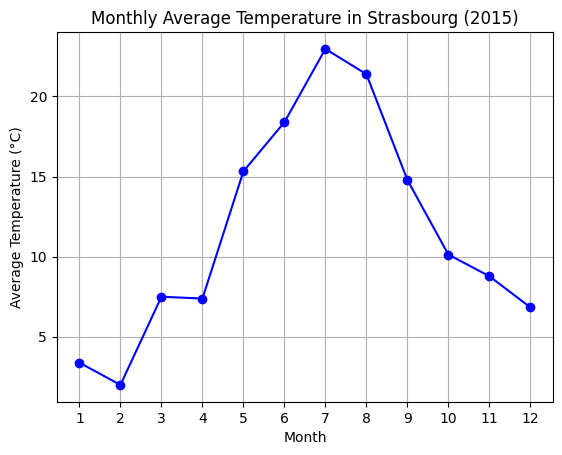

In [ ]:

def scan_line(x):
    station = x._c1
    c2 = x._c2
    c3 = x._c3
    c4 = x._c4
    c5 = x._c5
    c6 = x._c6
    return station, (c2, c3, c4, c5, c6)
df = spark.read.csv("strasbg_2015.csv")

#On etudie qu'une seule station , on enleve donc la colonne c0 (c7 est tjrs nulle)
df = df.drop("_c0")
df = df.drop("_c7")

rdd = df.rdd.map(scan_line)
# Average tempature
rdd_temp = rdd.filter(lambda x: x[1][0] == 'TAVG')
# The date is in the format 'YYYYMMDD' so we can extract the month using slicing
rdd_temp_by_month = rdd_temp.map(lambda x: (x[0][4:6], float(x[1][1]) / 10))
rdd_sum_count_month = rdd_temp_by_month.mapValues(lambda temp: (temp, 1)) \
                                       .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
rdd_avg_temp_month = rdd_sum_count_month.mapValues(lambda v: v[0] / v[1])

result_month = rdd_avg_temp_month.collect()
result_month.sort(key=lambda x: int(x[0]))  # Sort by the month (numeric order)

#for plotting
months = [int(row[0]) for row in result_month]
avg_temps = [row[1] for row in result_month]

# Plot the data using Matplotlib
import matplotlib.pyplot as plt

plt.plot(months, avg_temps, marker='o', linestyle='-', color='b')
plt.title('Monthly Average Temperature in Strasbourg (2015)')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(months)  # Show month numbers on x-axis
plt.grid(True)
plt.show()



This graph illustrates the annual temperature cycle, showing how the average monthly temperature rises from the coldest months in winter (January and December) to peak during the summer in July. The steady increase from winter to summer, followed by a decline toward the year's end, highlights a typical seasonal pattern, with warm summers and cold winters. This trend reflects the region’s temperate climate, characterized by significant variation between summer and winter temperatures.


Standard Deviation of Temperatures



In [ ]:
import math

# Extract temperatures once and we divide by 10 to turn theminto degrees
rdd_temps = rdd_temp.map(lambda x: float(x[1][1]) / 10)

# Mean
rdd_sum_count = rdd_temps.map(lambda temp: (temp, 1)) \
                         .reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))
mean_temp = rdd_sum_count[0] / rdd_sum_count[1]

# Variance
rdd_variance = rdd_temps.map(lambda temp: (temp - mean_temp) ** 2) \
                        .map(lambda sq_diff: (sq_diff, 1)) \
                        .reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

variance = rdd_variance[0] / (rdd_variance[1] - 1)
std_dev = math.sqrt(variance)

print(f"Mean Temperature: {mean_temp:.2f} °C")
print(f"Standard Deviation of Temperatures: {std_dev:.2f} °C")



Mean Temperature: 11.90 °C
Standard Deviation of Temperatures: 7.40 °C


The **mean temperature** of 11.90°C suggests a mild overall climate, while the **standard deviation** of 7.40°C indicates significant temperature variation, with a mix of hot and cold days throughout the year.

Q1 and Q3

In [ ]:
temps = rdd_temp.map(lambda x: float(x[1][1]) / 10).collect()
temps_sorted = sorted(temps)

def percentile(data, percentile):
    index = (len(data) - 1) * percentile / 100
    lower = int(index)
    upper = math.ceil(index)
    return data[lower] + (data[upper] - data[lower]) * (index - lower)

#1st and 3rd quartiles (25th and 75th percentiles)
q1 = percentile(temps_sorted, 25)
q3 = percentile(temps_sorted, 75)
print(f"1st Quartile (Q1) Temperature: {q1:.2f} °C")
print(f"3rd Quartile (Q3) Temperature: {q3:.2f} °C")


1st Quartile (Q1) Temperature: 6.07 °C
3rd Quartile (Q3) Temperature: 16.82 °C


The 1st Quartile (Q1) temperature of 6.07°C indicates that 25% of the temperatures in the dataset are below this value, while the 3rd Quartile (Q3) temperature of 16.82°C means that 75% of the temperatures are below this value.

Correlation Between Temperature and Precipitation (2015)

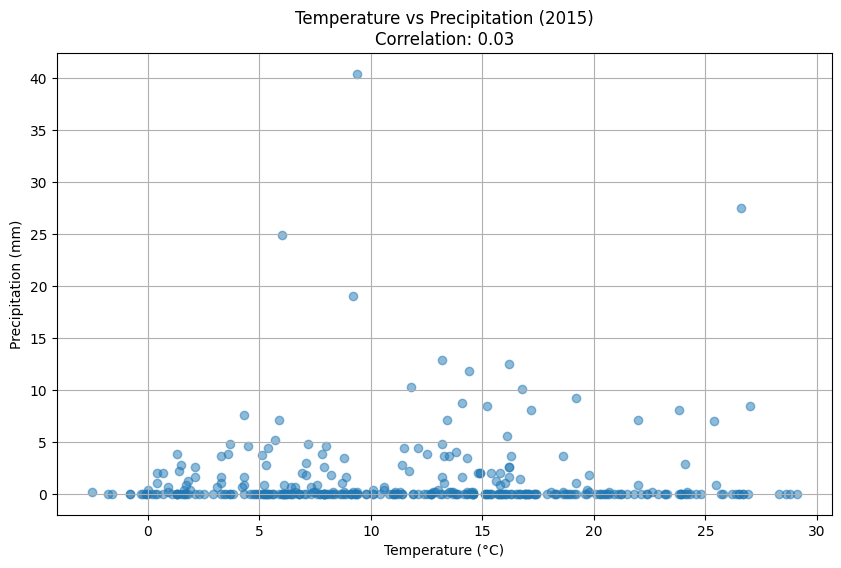

Correlation between Temperature and Precipitation in 2015: 0.03


In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Step 1: Filter for TAVG (temperature) and PRCP (precipitation)
df_filtered_temp = df.filter(df['_c2'] == 'TAVG')  # Get temp data
df_filtered_precip = df.filter(df['_c2'] == 'PRCP')  # Get precip data

# Step 2: Convert values to float and select relevant columns
df_temp = df_filtered_temp.withColumn('temperature', df_filtered_temp['_c3'].cast('float') / 10) \
                          .select('_c1', 'temperature')  # Get temp and date
df_precip = df_filtered_precip.withColumn('precipitation', df_filtered_precip['_c3'].cast('float') / 10) \
                              .select('_c1', 'precipitation')  # Get precip and date

# Step 3: Join temp and precip data by date
df_temp_precip = df_temp.join(df_precip, on='_c1')  # Join on date

# Step 4: Calculate correlation between temperature and precipitation
correlation = df_temp_precip.stat.corr('temperature', 'precipitation')  # Calculate correlation

# Step 5: Convert to Pandas DataFrame for plotting
pandas_df = df_temp_precip.toPandas()

# Step 6: Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['temperature'], pandas_df['precipitation'], alpha=0.5)
plt.title(f'Temperature vs Precipitation (2015)\nCorrelation: {correlation:.2f}')
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()

# Step 7: Print the correlation result
print(f"Correlation between Temperature and Precipitation in 2015: {correlation:.2f}")




Rainy days count

In [ ]:
# We filter precipitation  data where precipitation is greater than 0
rainy_days = df.filter((df['_c2'] == 'PRCP') & (df['_c3'].cast('float') > 0))
rainy_days_count = rainy_days.select('_c1').distinct().count()
print(f"Number of rainy days in 2015: {rainy_days_count}")



Number of rainy days in 2015: 133


##STRASBOURG OVER THE YEARS


In this analysis, I will load and process weather data for Strasbourg from multiple years (1950, 1970, 1990, 2010, 2015, and 2018) using PySpark. The data will be loaded from CSV files into DataFrames for each year. Since the data contains weather information for multiple stations, I will filter the DataFrames by Strasbourg’s station ID, 'FR000007190', to focus specifically on the weather patterns for this location. However, for 1950 and 1970, there is no average temperature (TAVG)  data available, so these two years will not be used in the first part of the analysis.

In [11]:
# Unzip each file
import gzip
import shutil

def unzip_file(file_path):
    with gzip.open(file_path, 'rb') as f_in:
        with open(file_path[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)


unzip_file('1950.csv.gz')
unzip_file('1970.csv.gz')
unzip_file('1990.csv.gz')
unzip_file('2010.csv.gz')
unzip_file('2015.csv.gz')
unzip_file('2018.csv.gz')


In [12]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("StrasbourgWeather").getOrCreate()

df_1950 = spark.read.csv("1950.csv", header=False)
df_1970 = spark.read.csv("1970.csv", header=False)
df_1990 = spark.read.csv("1990.csv", header=False)
df_2010 = spark.read.csv("2010.csv", header=False)
df_2015 = spark.read.csv("2015.csv", header=False)
df_2018 = spark.read.csv("2018.csv", header=False)

strasbourg_station_id = 'FR000007190'

df_1950_strasbourg = df_1950.filter(df_1950['_c0'] == strasbourg_station_id)
df_1970_strasbourg = df_1970.filter(df_1970['_c0'] == strasbourg_station_id)
df_1990_strasbourg = df_1990.filter(df_1990['_c0'] == strasbourg_station_id)
df_2010_strasbourg = df_2010.filter(df_2010['_c0'] == strasbourg_station_id)
df_2015_strasbourg = df_2015.filter(df_2015['_c0'] == strasbourg_station_id)
df_2018_strasbourg = df_2018.filter(df_2018['_c0'] == strasbourg_station_id)



In [19]:
df_1990_strasbourg.show()

+-----------+--------+----+---+----+----+---+----+
|        _c0|     _c1| _c2|_c3| _c4| _c5|_c6| _c7|
+-----------+--------+----+---+----+----+---+----+
|FR000007190|19900101|TMAX|-21|NULL|NULL|  E|NULL|
|FR000007190|19900101|TMIN|-31|NULL|NULL|  E|NULL|
|FR000007190|19900101|PRCP|  0|NULL|NULL|  E|NULL|
|FR000007190|19900101|TAVG|-24|   H|NULL|  S|NULL|
|FR000007190|19900102|TMAX|-23|NULL|NULL|  E|NULL|
|FR000007190|19900102|TMIN|-32|NULL|NULL|  E|NULL|
|FR000007190|19900102|PRCP|  0|NULL|NULL|  E|NULL|
|FR000007190|19900102|TAVG|-27|   H|NULL|  S|NULL|
|FR000007190|19900103|TMAX|  2|NULL|NULL|  E|NULL|
|FR000007190|19900103|TMIN|-30|NULL|NULL|  E|NULL|
|FR000007190|19900103|PRCP|  0|NULL|NULL|  E|NULL|
|FR000007190|19900103|TAVG|-10|   H|NULL|  S|NULL|
|FR000007190|19900104|TMAX|  0|NULL|NULL|  E|NULL|
|FR000007190|19900104|TMIN| -9|NULL|NULL|  E|NULL|
|FR000007190|19900104|PRCP|  0|NULL|NULL|  E|NULL|
|FR000007190|19900104|TAVG| -4|   H|NULL|  S|NULL|
|FR000007190|19900105|TMAX| 16|

Mean for 1990: 11.214794520547942, Standard Deviation for 1990: 6.831951547257897
Mean for 2010: 10.096164383561643, Standard Deviation for 2010: 8.129195587786338
Mean for 2015: 11.958630136986303, Standard Deviation for 2015: 7.196080614172349
Mean for 2018: 12.589041095890408, Standard Deviation for 2018: 7.850115811794445


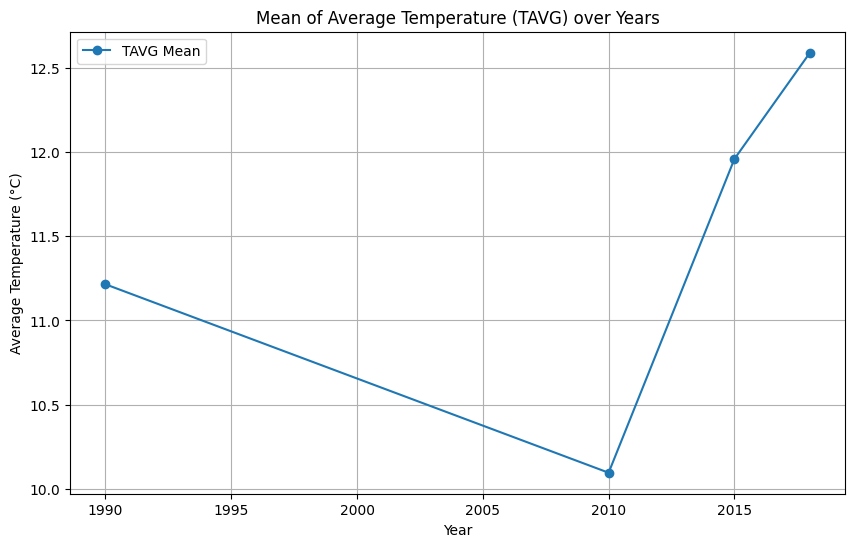

In [32]:
import math
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

def calculate_mean(rdd):
    rdd_tavg = rdd.filter(lambda row: row[1][0] == 'TAVG')
    rdd_temp = rdd_tavg.map(lambda row: float(row[1][1]) / 10)
    sum_count = rdd_temp.map(lambda temp: (temp, 1)).reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    mean_temp = sum_count[0] / sum_count[1]
    return mean_temp

def calculate_std_dev(rdd, mean_temp):
    rdd_tavg = rdd.filter(lambda row: row[1][0] == 'TAVG')
    rdd_temp = rdd_tavg.map(lambda row: float(row[1][1]) / 10)
    variance_rdd = rdd_temp.map(lambda temp: (temp - mean_temp) ** 2)
    variance_sum_count = variance_rdd.map(lambda sq_diff: (sq_diff, 1)).reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    variance = variance_sum_count[0] / variance_sum_count[1]
    std_dev = math.sqrt(variance)
    return std_dev


def convert_to_rdd(df):
    return df.rdd.map(lambda row: (row['_c1'], (row['_c2'], row['_c3'])))

rdd_1950 = convert_to_rdd(df_1950_strasbourg)
rdd_1970 = convert_to_rdd(df_1970_strasbourg)
rdd_1990 = convert_to_rdd(df_1990_strasbourg)
rdd_2010 = convert_to_rdd(df_2010_strasbourg)
rdd_2015 = convert_to_rdd(df_2015_strasbourg)
rdd_2018 = convert_to_rdd(df_2018_strasbourg)


mean_1990 = calculate_mean(rdd_1990)
mean_2010 = calculate_mean(rdd_2010)
mean_2015 = calculate_mean(rdd_2015)
mean_2018 = calculate_mean(rdd_2018)

std_dev_1990 = calculate_std_dev(rdd_1990, mean_1990)
std_dev_2010 = calculate_std_dev(rdd_2010, mean_2010)
std_dev_2015 = calculate_std_dev(rdd_2015, mean_2015)
std_dev_2018 = calculate_std_dev(rdd_2018, mean_2018)


print(f"Mean for 1990: {mean_1990}, Standard Deviation for 1990: {std_dev_1990}")
print(f"Mean for 2010: {mean_2010}, Standard Deviation for 2010: {std_dev_2010}")
print(f"Mean for 2015: {mean_2015}, Standard Deviation for 2015: {std_dev_2015}")
print(f"Mean for 2018: {mean_2018}, Standard Deviation for 2018: {std_dev_2018}")

# Plot the results
years = [ 1990, 2010, 2015, 2018]
means = [ mean_1990, mean_2010, mean_2015, mean_2018]
std_devs = [ std_dev_1990, std_dev_2010, std_dev_2015, std_dev_2018]

plt.figure(figsize=(10, 6))
plt.plot(years, means, '-o', label='TAVG Mean')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.title('Mean of Average Temperature (TAVG) over Years')
plt.legend()
plt.grid(True)
plt.show()




```
# Ce texte est au format code
```

Temperature Quartiles (Q1 and Q3) Over the Years

Quartiles for 1990: Q1=6.6, Q3=16.3
Quartiles for 2010: Q1=3.2, Q3=16.5
Quartiles for 2015: Q1=6.2, Q3=16.6
Quartiles for 2018: Q1=5.9, Q3=19.6


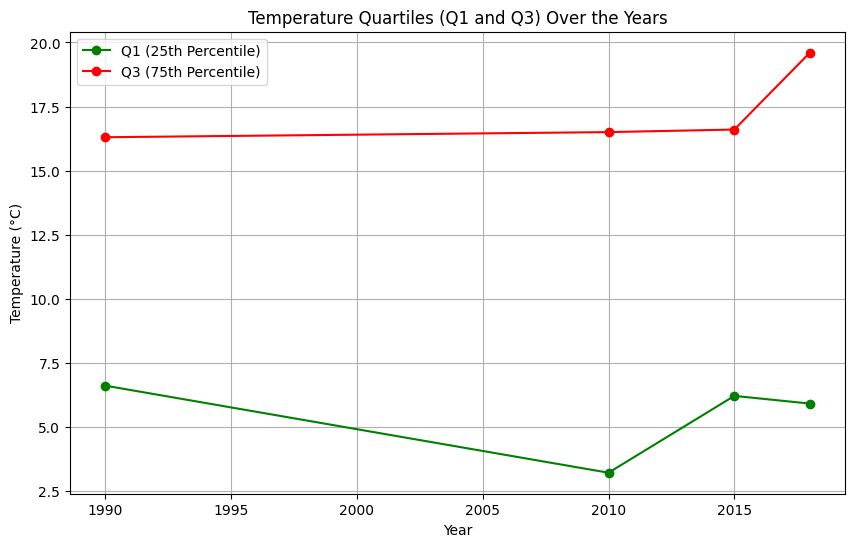

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def percentile(sorted_data, percentile_rank):
    n = len(sorted_data)
    rank = (percentile_rank / 100) * (n - 1)
    lower = int(np.floor(rank))
    upper = int(np.ceil(rank))
    weight = rank - lower
    return sorted_data[lower] * (1 - weight) + sorted_data[upper] * weight


def calculate_quartiles(rdd): #same as before
    rdd_tavg = rdd.filter(lambda x: x[1][0] == 'TAVG')
    temps = rdd_tavg.map(lambda x: float(x[1][1]) / 10).collect()
    temps_sorted = sorted(temps)
    q1 = percentile(temps_sorted, 25)
    q3 = percentile(temps_sorted, 75)

    return q1, q3


q1_1990, q3_1990 = calculate_quartiles(rdd_1990)
q1_2010, q3_2010 = calculate_quartiles(rdd_2010)
q1_2015, q3_2015 = calculate_quartiles(rdd_2015)
q1_2018, q3_2018 = calculate_quartiles(rdd_2018)

print(f"Quartiles for 1990: Q1={q1_1990}, Q3={q3_1990}")
print(f"Quartiles for 2010: Q1={q1_2010}, Q3={q3_2010}")
print(f"Quartiles for 2015: Q1={q1_2015}, Q3={q3_2015}")
print(f"Quartiles for 2018: Q1={q1_2018}, Q3={q3_2018}")

years = [ 1990, 2010, 2015, 2018]
q1_values = [ q1_1990, q1_2010, q1_2015, q1_2018]
q3_values = [ q3_1990, q3_2010, q3_2015, q3_2018]

# Plot Q1 and Q3 over the years
plt.figure(figsize=(10, 6))
plt.plot(years, q1_values, marker='o', linestyle='-', color='g', label='Q1 (25th Percentile)')
plt.plot(years, q3_values, marker='o', linestyle='-', color='r', label='Q3 (75th Percentile)')

# labels, title, and legend
plt.title('Temperature Quartiles (Q1 and Q3) Over the Years')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()



In [29]:
def count_rainy_days(rdd):
    rdd_prcp = rdd.filter(lambda x: x[1][0] == 'PRCP').map(lambda x: (x[0], float(x[1][1])))
    rdd_rainy_days = rdd_prcp.filter(lambda x: x[1] > 0)
    rainy_days_count = rdd_rainy_days.map(lambda x: x[0]).distinct().count()
    return rainy_days_count
rainy_days_1950 = count_rainy_days(rdd_1950)
rainy_days_1970 = count_rainy_days(rdd_1970)
rainy_days_1990 = count_rainy_days(rdd_1990)
rainy_days_2010 = count_rainy_days(rdd_2010)
rainy_days_2015 = count_rainy_days(rdd_2015)
rainy_days_2018 = count_rainy_days(rdd_2018)

print(f"Rainy Days: 1950={rainy_days_1950}, 1970={rainy_days_1970}, 1990={rainy_days_1990}, 2010={rainy_days_2010}, 2015={rainy_days_2015}, 2018={rainy_days_2018}")





Rainy Days: 1950=157, 1970=184, 1990=153, 2010=212, 2015=133, 2018=143


In [30]:
def count_extreme_events(rdd, heatwave_threshold, cold_spell_threshold):
    rdd_tmax = rdd.filter(lambda x: x[1][0] == 'TMAX').map(lambda x: (x[0], float(x[1][1]) / 10))
    rdd_tmin = rdd.filter(lambda x: x[1][0] == 'TMIN').map(lambda x: (x[0], float(x[1][1]) / 10))
    rdd_heatwave = rdd_tmax.filter(lambda x: x[1] > heatwave_threshold)
    rdd_cold_spell = rdd_tmin.filter(lambda x: x[1] < cold_spell_threshold)
    heatwave_days = rdd_heatwave.count()
    cold_spell_days = rdd_cold_spell.count()

    return heatwave_days, cold_spell_days

heatwave_threshold = 30  # I dzefined a heatwave as  TMAX > 30°C ( se)
cold_spell_threshold = 0  # same for cold spell  TMIN < 0°C

heatwave_days_1950, cold_spell_days_1950 = count_extreme_events(rdd_1950, heatwave_threshold, cold_spell_threshold)
heatwave_days_1970, cold_spell_days_1970 = count_extreme_events(rdd_1970, heatwave_threshold, cold_spell_threshold)
heatwave_days_1990, cold_spell_days_1990 = count_extreme_events(rdd_1990, heatwave_threshold, cold_spell_threshold)
heatwave_days_2010, cold_spell_days_2010 = count_extreme_events(rdd_2010, heatwave_threshold, cold_spell_threshold)
heatwave_days_2015, cold_spell_days_2015 = count_extreme_events(rdd_2015, heatwave_threshold, cold_spell_threshold)
heatwave_days_2018, cold_spell_days_2018 = count_extreme_events(rdd_2018, heatwave_threshold, cold_spell_threshold)

print(f"Heatwave Days (1950): {heatwave_days_1950}, Cold Spell Days (1950): {cold_spell_days_1950}")
print(f"Heatwave Days (1970): {heatwave_days_1970}, Cold Spell Days (1970): {cold_spell_days_1970}")
print(f"Heatwave Days (1990): {heatwave_days_1990}, Cold Spell Days (1990): {cold_spell_days_1990}")
print(f"Heatwave Days (2010): {heatwave_days_2010}, Cold Spell Days (2010): {cold_spell_days_2010}")
print(f"Heatwave Days (2015): {heatwave_days_2015}, Cold Spell Days (2015): {cold_spell_days_2015}")
print(f"Heatwave Days (2018): {heatwave_days_2018}, Cold Spell Days (2018): {cold_spell_days_2018}")



Heatwave Days (1950): 13, Cold Spell Days (1950): 81
Heatwave Days (1970): 2, Cold Spell Days (1970): 89
Heatwave Days (1990): 13, Cold Spell Days (1990): 49
Heatwave Days (2010): 18, Cold Spell Days (2010): 79
Heatwave Days (2015): 34, Cold Spell Days (2015): 49
Heatwave Days (2018): 36, Cold Spell Days (2018): 57


Studying heatwaves and cold spells over time can show how the climate is changing. An increase in hot days, with fewer cold spells, might suggest rising temperatures in the area. This trend helps highlight how the weather is becoming more extreme, with more frequent heatwaves indicating a warming pattern.

In [31]:
def calculate_annual_rainfall(rdd):
    rdd_prcp = rdd.filter(lambda x: x[1][0] == 'PRCP').map(lambda x: (x[0][:4], float(x[1][1]) / 10))
    total_rainfall_by_year = rdd_prcp.reduceByKey(lambda a, b: a + b).collect()
    return sorted(total_rainfall_by_year)

def count_heavy_rainfall_days(rdd, threshold=20):
    rdd_prcp = rdd.filter(lambda x: x[1][0] == 'PRCP').map(lambda x: (x[0][:4], float(x[1][1]) / 10))
    heavy_rainfall_days = rdd_prcp.filter(lambda x: x[1] > threshold)
    heavy_rainfall_count_by_year = heavy_rainfall_days.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b).collect()
    return sorted(heavy_rainfall_count_by_year)

annual_rainfall_1950 = calculate_annual_rainfall(rdd_1950)
annual_rainfall_1970 = calculate_annual_rainfall(rdd_1970)
annual_rainfall_1990 = calculate_annual_rainfall(rdd_1990)
annual_rainfall_2010 = calculate_annual_rainfall(rdd_2010)
annual_rainfall_2015 = calculate_annual_rainfall(rdd_2015)
annual_rainfall_2018 = calculate_annual_rainfall(rdd_2018)

heavy_rainfall_days_1950 = count_heavy_rainfall_days(rdd_1950)
heavy_rainfall_days_1970 = count_heavy_rainfall_days(rdd_1970)
heavy_rainfall_days_1990 = count_heavy_rainfall_days(rdd_1990)
heavy_rainfall_days_2010 = count_heavy_rainfall_days(rdd_2010)
heavy_rainfall_days_2015 = count_heavy_rainfall_days(rdd_2015)
heavy_rainfall_days_2018 = count_heavy_rainfall_days(rdd_2018)

print("Annual Rainfall Totals:", annual_rainfall_1950, annual_rainfall_1970, annual_rainfall_1990, annual_rainfall_2010, annual_rainfall_2015, annual_rainfall_2018)
print("Heavy Rainfall Days:", heavy_rainfall_days_1950, heavy_rainfall_days_1970, heavy_rainfall_days_1990, heavy_rainfall_days_2010, heavy_rainfall_days_2015, heavy_rainfall_days_2018)


Annual Rainfall Totals: [('1950', 664.5999999999999)] [('1970', 585.6999999999997)] [('1990', 623.4000000000002)] [('2010', 794.2)] [('2015', 474.70000000000005)] [('2018', 612.0)]
Heavy Rainfall Days: [('1950', 4)] [('1970', 1)] [('1990', 3)] [('2010', 6)] [('2015', 3)] [('2018', 5)]


 Both total rainfall and heavy rainfall days show fluctuations with 2010 standing out as the year with the most rainfall and the most heavy rainfall events possibly indicating more intense weather patterns in that year.

#Comparaison with Tunisia STATION

In [13]:
df_2018 = spark.read.csv("2018.csv", header=False)

In [ ]:

df_2018.select('_c0').distinct().show(10)


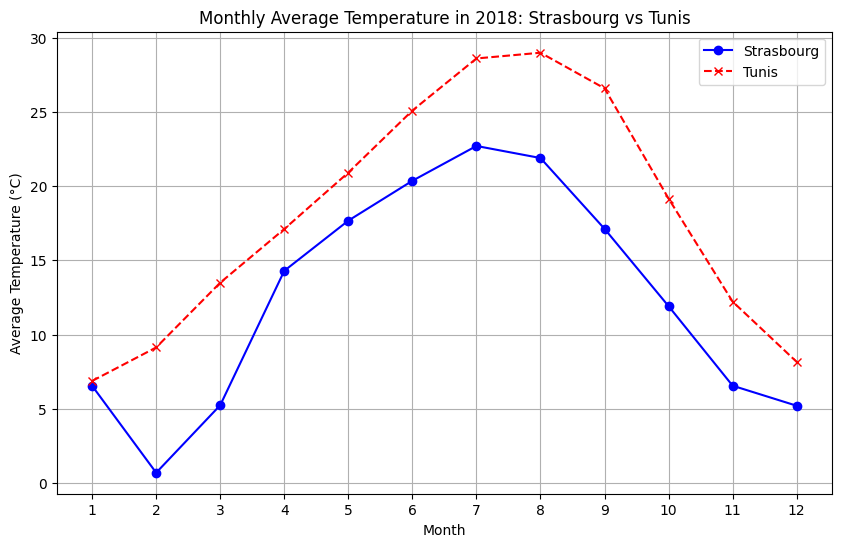

In [26]:

strasbourg_station_id = 'FR000007190'
tunis_station_id = 'TUM00017255'
df_2018_strasbourg = df_2018.filter(df_2018['_c0'] == strasbourg_station_id)
df_2018_tunis = df_2018.filter(df_2018['_c0'] == tunis_station_id)
df_2018_strasbourg = df_2018_strasbourg.drop("_c0").drop("_c7")
df_2018_tunis = df_2018_tunis.drop("_c0").drop("_c7")

def scan_line(x):
    station = x._c1
    c2 = x._c2
    c3 = x._c3
    c4 = x._c4
    c5 = x._c5
    c6 = x._c6
    return station, (c2, c3, c4, c5, c6)
rdd_strasbourg = df_2018_strasbourg.rdd.map(scan_line)
rdd_tunis = df_2018_tunis.rdd.map(scan_line)

def calculate_monthly_avg_temp(rdd):
    rdd_temp = rdd.filter(lambda x: x[1][0] == 'TAVG')
    rdd_temp_by_month = rdd_temp.map(lambda x: (x[0][4:6], float(x[1][1]) / 10))
    rdd_sum_count_month = rdd_temp_by_month.mapValues(lambda temp: (temp, 1)) \
                                           .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    rdd_avg_temp_month = rdd_sum_count_month.mapValues(lambda v: v[0] / v[1])
    result_month = rdd_avg_temp_month.collect()
    result_month.sort(key=lambda x: int(x[0]))

avg_temp_month_strasbourg = calculate_monthly_avg_temp(rdd_strasbourg)
avg_temp_month_tunis = calculate_monthly_avg_temp(rdd_tunis)
months_strasbourg = [int(row[0]) for row in avg_temp_month_strasbourg]
avg_temps_strasbourg = [row[1] for row in avg_temp_month_strasbourg]

months_tunis = [int(row[0]) for row in avg_temp_month_tunis]
avg_temps_tunis = [row[1] for row in avg_temp_month_tunis]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(months_strasbourg, avg_temps_strasbourg, marker='o', linestyle='-', color='b', label='Strasbourg')
plt.plot(months_tunis, avg_temps_tunis, marker='x', linestyle='--', color='r', label='Tunis')
plt.title('Monthly Average Temperature in 2018: Strasbourg vs Tunis')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(months_strasbourg)
plt.legend()
plt.grid(True)
plt.show()



In 2018, the monthly average temperatures for Strasbourg and Tunis highlight notable differences between the two cities' climates. Tunis consistently experiences warmer temperatures, particularly in the summer months, where the average peaks at nearly 30°C. In contrast, Strasbourg’s peak summer temperatures remain around 20°C. Both cities show similar seasonal patterns, with colder months in winter and warmer months in summer. However, Strasbourg experiences significantly cooler winters, with temperatures dropping close to 0°C, while Tunis remains much warmer, with winter temperatures staying above 5°C. This comparison reflects Tunis's Mediterranean climate, characterized by higher and more stable temperatures year-round, while Strasbourg shows greater seasonal variation typical of a continental climate.